In [54]:
import numpy as np
import json
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from FCPython import createPitch
from FCPython import createGoalMouth
from mplsoccer import VerticalPitch
import sys
import ast

In [2]:
def importSBMatches(file_name, path='data/matches/2/'):
    with open(path+file_name) as data_file:
        #print (mypath+'events/'+file)
        data = json.load(data_file)
    
    #get the nested structure into a dataframe 
    #store the dataframe in a dictionary with the match id as key (remove '.json' from string)
    df = pd.json_normalize(data, sep = "_")
    return df

def getShots(events):
    #Get penalties from event data, keeping only useful columns
    shots = events.loc[events['type_name'] == 'Shot'].set_index('id')
    keep_cols = ['match_id','minute','team_id','team_name','player_id','player_name',
             'shot_body_part_name','shot_technique_name','shot_outcome_name']
    return pens[keep_cols]

def importSBjson(file_name, path='data/events/'):
    with open(path+file_name) as data_file:
        #print (mypath+'events/'+file)
        data = json.load(data_file)
    
    #get the nested structure into a dataframe 
    #store the dataframe in a dictionary with the match id as key (remove '.json' from string)
    df = pd.json_normalize(data, sep = "_").assign(match_id = file_name[:-5])
    return df

In [3]:
# A utility function to calculate area of triangle formed by (x1, y1),
# (x2, y2) and (x3, y3)
def area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)

# A function to check whether point P(x, y) lies inside the triangle formed by
# A(x1, y1), B(x2, y2) and C(x3, y3)
def isInside(x1, y1, x2, y2, x3, y3, x, y):
    # Calculate area of triangle ABC
    A = area (x1, y1, x2, y2, x3, y3)
 
    # Calculate area of triangle PBC
    A1 = area (x, y, x2, y2, x3, y3)
     
    # Calculate area of triangle PAC
    A2 = area (x1, y1, x, y, x3, y3)
     
    # Calculate area of triangle PAB
    A3 = area (x1, y1, x2, y2, x, y)
     
    # Check if sum of A1, A2 and A3
    # is same as A
    if(A == A1 + A2 + A3):
        return True
    else:
        return False

In [4]:
def getFreezeFrame(shots, shot_id):
    onevone = shots.copy()
    ### Plot a shooting Situation
    #onevone['shot_freeze_frame'][shot_id][0]['position']['name']
    shooter_x = onevone['location'][shot_id][0]
    shooter_y = onevone['location'][shot_id][1]

    num_players = len(onevone['shot_freeze_frame'][shot_id])
    is_gk = np.zeros(num_players)
    is_teammate = np.zeros(num_players)
    freeze_frame_x = np.zeros(num_players)
    freeze_frame_y = np.zeros(num_players)
    for i in range(num_players):
        freeze_frame_x[i] = onevone['shot_freeze_frame'][shot_id][i]['location'][0]
        freeze_frame_y[i] = onevone['shot_freeze_frame'][shot_id][i]['location'][1]
        is_gk[i] = onevone['shot_freeze_frame'][shot_id][i]['position']['name'] == 'Goalkeeper'
        is_teammate[i] = onevone['shot_freeze_frame'][shot_id][i]['teammate']

    attacking_team_x = freeze_frame_x[is_teammate.astype(bool)]
    attacking_team_y = freeze_frame_y[is_teammate.astype(bool)]
    defending_team_x = freeze_frame_x[~ is_teammate.astype(bool)]
    defending_team_y = freeze_frame_y[~ is_teammate.astype(bool)]
    gk_x = freeze_frame_x[is_gk.astype(bool)]
    gk_y = freeze_frame_y[is_gk.astype(bool)]
    return shooter_x,shooter_y,attacking_team_x,attacking_team_y,defending_team_x,defending_team_y,gk_x,gk_y

In [31]:
type(getFreezeFrame(wc_1v1s, shot_id=1)[4]) == np.ndarray

True

In [32]:
np.array([1])

array([1])

In [34]:
#Filter for 1v1s
#A 1v1 is where the gk is the only defending player in the triangle between the striker
#and the goal posts, and the striker is further up the pitch (x) than any defender
def is1v1(shots, shot_id):
    shooter_x,shooter_y,_,_,defending_team_x,defending_team_y,gk_x,gk_y = getFreezeFrame(shots, shot_id=shot_id)
    if len(gk_x) > 0:
        remove_gk = ~((defending_team_x == gk_x) & (defending_team_y == gk_y))
        defending_team_x = defending_team_x[remove_gk]
        defending_team_y = defending_team_y[remove_gk]
        post_x = 120
        post_1_y = 36
        post_2_y = 44
        #Check the GK is between the striker and the goal
        gk_in_triangle = isInside(shooter_x, shooter_y, post_x, post_1_y, post_x, post_2_y, gk_x[0], gk_y[0])
        if type(defending_team_x) != np.ndarray:
            defending_team_x = np.array([defending_team_x])
            defending_team_y = np.array([defending_team_y])
        num_defenders = len(defending_team_x)
        defender_in_triangle = np.zeros(num_defenders)
        for d in range(num_defenders):
            defender_in_triangle[d] = isInside(shooter_x, shooter_y, post_x, post_1_y, post_x, post_2_y, defending_team_x[d], defending_team_y[d])   
        isonevone = (gk_in_triangle) & (np.sum(defender_in_triangle) == 0) & (shooter_x >= np.max(defending_team_x))
        if isonevone:
            return True
        else:
            return False
    else:
        return False

In [36]:
def get1v1Data(match_path, match_file, event_path, save):
    matches_wc = importSBMatches(match_file, path=match_path)
    match_ids = matches_wc.match_id
    #Get all shots in the World Cup
    wc_shots = pd.DataFrame()
    for m_id in match_ids:
        file_name = str(m_id) + '.json'
        events = importSBjson(file_name, path=event_path)
        shots = events.loc[events['type_name'] == 'Shot']
        wc_shots = wc_shots.append(shots, ignore_index=True)
    #Filter for shots with feet that are also from open play
    shots = wc_shots[(wc_shots['shot_body_part_name'] == 'Right Foot') | (wc_shots['shot_body_part_name'] == 'Left Foot')].copy()
    shots = shots[shots['shot_type_name'] == 'Open Play'].copy()
    keep_columns = ['timestamp','duration','play_pattern_name','team_name','location',
                    'player_id','player_name','under_pressure','shot_end_location',
                    'shot_outcome_name','shot_body_part_name','shot_technique_name',
                    'shot_freeze_frame','shot_first_time','match_id']
    shots = shots[keep_columns].copy().reset_index(drop=True)
    shots['onevone'] = np.zeros(len(shots))
    #Filter for 1v1s
    for i in range(len(shots)):
        shots.loc[i, 'onevone'] = is1v1(shots, shot_id=i)
        if i % 100 == 0:
            print(i)
    onevones = shots[shots.onevone == True].reset_index(drop=True).copy()
    onevones['match_id'] = onevones['match_id'].astype(int)
    match_info = matches_wc[['match_id','match_date','home_team_home_team_name','away_team_away_team_name']].copy()
    onevones = pd.merge(onevones, match_info, on='match_id', how='left')
    onevones.to_csv(save, index=True)
    return onevones

In [72]:
def plotShot(shots, shot_id, save=False, save_name='example_shot'):
    onevone = shots.copy()
    ### Plot a shooting Situation
    #onevone['shot_freeze_frame'][shot_id][0]['position']['name']
    #shooter_x = onevone['location'][shot_id][0]
    #shooter_y = onevone['location'][shot_id][1]

    #num_players = len(onevone['shot_freeze_frame'][shot_id])
    #is_gk = np.zeros(num_players)
    #is_teammate = np.zeros(num_players)
    #freeze_frame_x = np.zeros(num_players)
    #freeze_frame_y = np.zeros(num_players)
    #for i in range(num_players):
    #    freeze_frame_x[i] = onevone['shot_freeze_frame'][shot_id][i]['location'][0]
    #    freeze_frame_y[i] = onevone['shot_freeze_frame'][shot_id][i]['location'][1]
    #    is_gk[i] = onevone['shot_freeze_frame'][shot_id][i]['position']['name'] == 'Goalkeeper'
    #    is_teammate[i] = onevone['shot_freeze_frame'][shot_id][i]['teammate']

    #attacking_team_x = freeze_frame_x[is_teammate.astype(bool)]
    #attacking_team_y = freeze_frame_y[is_teammate.astype(bool)]
    #defending_team_x = freeze_frame_x[~ is_teammate.astype(bool)]
    #defending_team_y = freeze_frame_y[~ is_teammate.astype(bool)]
    #gk_x = freeze_frame_x[is_gk.astype(bool)]
    #gk_y = freeze_frame_y[is_gk.astype(bool)]
    
    shooter_x,shooter_y,attacking_team_x,attacking_team_y,defending_team_x,defending_team_y,gk_x,gk_y = getFreezeFrame(onevone, shot_id)

    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20, 
                          pitch_color='white', line_color='#31363f')

    # We will use mplsoccer's grid function to plot a pitch with a title axis.
    fig, axs = pitch.grid(figheight=8, endnote_height=0,  # no endnote
                          title_height=0.1, title_space=0.02,
                          # Turn off the endnote/title axis. I usually do this after
                          # I am happy with the chart layout and text placement
                          axis=False,
                          grid_height=0.83)

    marker_size = 500

    sc1 = pitch.scatter(attacking_team_x, attacking_team_y, s=marker_size, c='#727cce', 
                        label='Attacker', ax=axs['pitch'], zorder=10)

    sc2 = pitch.scatter(defending_team_x, defending_team_y, s=marker_size,
                        c='#5ba965', label='Defender', ax=axs['pitch'], zorder=9) #Includes GK

    sc3 = pitch.scatter(gk_x, gk_y, s=marker_size,
                        ax=axs['pitch'], c='#c15ca5', label='Goalkeeper', zorder=11)

    sc4 = pitch.scatter(shooter_x, shooter_y, c='#727cce',
                        s=marker_size, ax=axs['pitch'], label='Striker', zorder=12)

    sc5 = pitch.scatter(shooter_x + 0.6, shooter_y, marker='football',
                        s=marker_size / 2, ax=axs['pitch'], zorder=20)

    sc6 = pitch.goal_angle(shooter_x, shooter_y, alpha=0.2, color='red', 
                           ax=axs['pitch'], goal='right',zorder=1)

    legend = axs['pitch'].legend(loc='center left', labelspacing=1.5)
    for text in legend.get_texts():
        #text.set_fontproperties(robotto_regular.prop)
        text.set_fontsize(20)
        text.set_va('center')

    if save:
        plt.savefig('../PoseAnalysis/viz/' + save_name + '.png', dpi=500)

## Collect 1v1s from Statsbomb

In [11]:
#Get World Cup 2018 1v1s
match_path = 'open-data/data/matches/43/'
match_file = '3.json'
event_path = 'open-data/data/events/'
save = 'worldcup_1v1s.csv'
wc_1v1s = get1v1Data(match_path, match_file, event_path, save)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [37]:
#Get Premier Leauge 2017/2018 1v1s
match_path = 'data/matches/2/'
match_file = '1.json'
event_path = 'data/events/'
save = 'prem1718_1v1s.csv'
prem1718_1v1s = get1v1Data(match_path, match_file, event_path, save)

0
100
200
300
400
500
600
700
800
900
1000


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300


In [39]:
#Get Premier Leauge 2018/2019 1v1s
match_path = 'data/matches/2/'
match_file = '4.json'
event_path = 'data/events/'
save = 'prem1819_1v1s.csv'
prem1819_1v1s = get1v1Data(match_path, match_file, event_path, save)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300


In [41]:
#Get Premier Leauge 2018/2019 1v1s
match_path = 'data/matches/2/'
match_file = '4.json'
event_path = 'data/events/'
save = 'prem1819_1v1s.csv'
prem1819_1v1s = get1v1Data(match_path, match_file, event_path, save)

0      2019-03-02
1      2019-04-20
2      2018-12-01
3      2019-02-10
4      2019-02-10
          ...    
446    2018-10-28
447    2018-10-28
448    2018-10-28
449    2018-10-05
450    2019-02-03
Name: match_date, Length: 451, dtype: object

In [86]:
#Combine individual season datasets to create master dataset csv of all 1v1s to analyse
files = ['worldcup_1v1s.csv','prem1718_1v1s.csv','prem1819_1v1s.csv']
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
df_1v1 = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, index_col=0, converters=converter)
    df_1v1 = df_1v1.append(df, ignore_index=True)
df_1v1.to_csv('1v1s.csv', index=True)

## Analyse 1v1 Data

In [88]:
#Import all 1v1s to analyse
df_1v1s = pd.read_csv('1v1s.csv', index_col=0, converters=converter)

In [139]:
def get1v1Info(df_1v1s, sid):
    print(np.array(df_1v1s.loc[sid,['team_name','player_name','shot_outcome_name',
                                    'home_team_home_team_name','away_team_away_team_name',
                                    'match_date','play_pattern_name']]))
    plotShot(df_1v1s, shot_id=sid)

['Denmark' 'Martin Braithwaite Christensen' 'Saved' 'Croatia' 'Denmark'
 '2018-07-01' 'Regular Play']


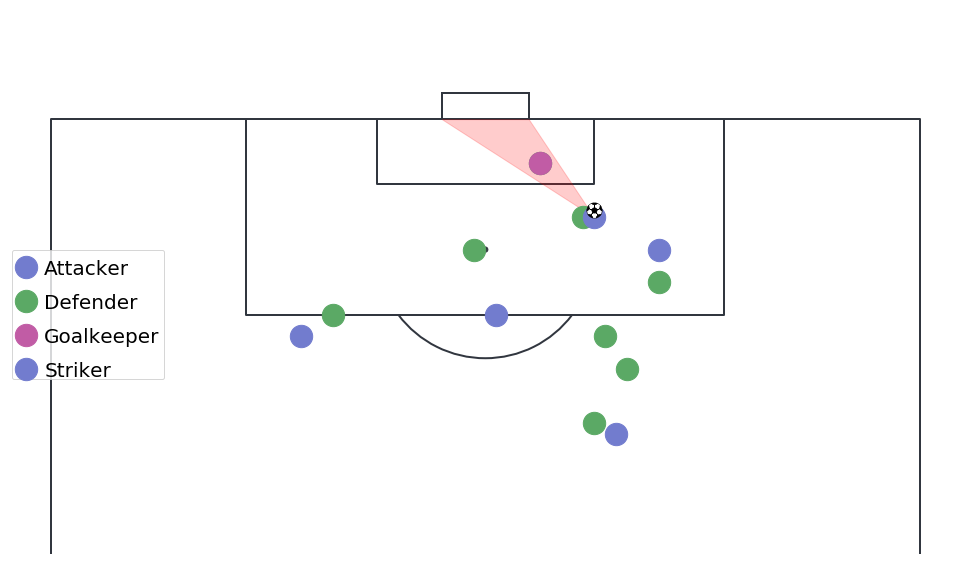

In [147]:
get1v1Info(df_1v1s, sid=0)